In [3]:
import pandas as pd

df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df_clean = df.dropna()
df_clean = df_clean.drop_duplicates()
df = df_clean

In [5]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [6]:
numeric_cols = df.select_dtypes(include=['number']).columns

# Apply IQR method to remove outliers
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Filtering out outliers
df_filtered = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Display the cleaned DataFrame
print(df_filtered.shape) 

(349025, 8)


In [7]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

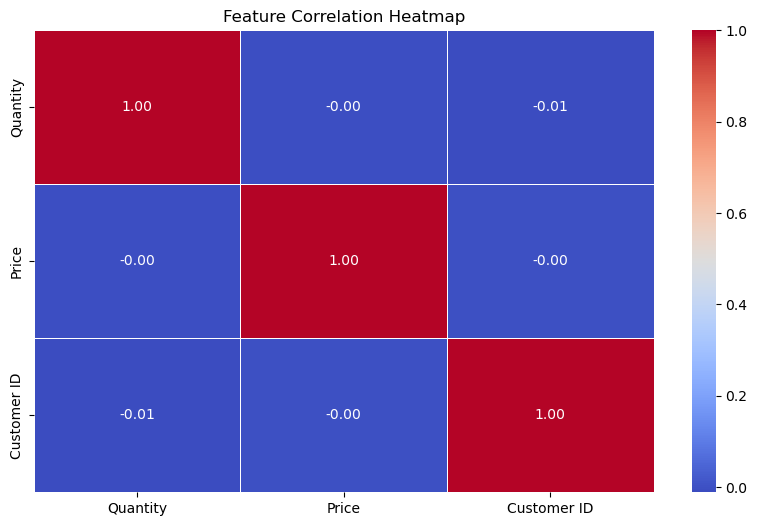

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
num_cols = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = num_cols.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler
df['TotalPrice'] = df['Quantity'] * df['Price']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['TotalPrice'].values.reshape(-1, 1))

In [10]:
df = df.sort_values('InvoiceDate')

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

scaled_data = df['TotalPrice'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with time steps
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

# Reshape the input to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

In [19]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, batch_size=32, epochs=1)

/Users/nishanholla/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12836/12836 ━━━━━━━━━━━━━━━━━━━━ 155s 12ms/step - loss: 4.6940e-04


In [12]:
# Split the data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
import joblib
model = joblib.load('model.pkl')

In [ ]:


# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
rmse_train = np.sqrt(np.mean((train_predict - y_train[0]) ** 2))
rmse_test = np.sqrt(np.mean((test_predict - y_test[0]) ** 2))

print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')

   18/10269 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step    

2025-02-05 15:57:05.823447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10269/10269 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step
2567/2567 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


AttributeError: 'Sequential' object has no attribute 'inverse_transform'

In [ ]:
validation_loss = model.evaluate(X_val, y_val)
print("Validation Loss: ", validation_loss)

test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have stored the history of loss values
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 3. Hyperparameter Tuning:

In [ ]:
# 4. Add Regularization (If Necessary):

In [ ]:
import joblib
joblib.dump(model, 'lstm_model.pkl')

In [ ]:
# 9. Fine-tuning and Advanced Techniques:
# 	•	If your results are still not satisfactory, explore more advanced techniques like:
# 	•	Bidirectional LSTM: To capture dependencies in both forward and backward directions.
# 	•	Attention Mechanism: To focus the model on more relevant parts of the sequence.
# 	•	Hybrid Models: Combining LSTM with other models such as CNNs for feature extraction.

In [15]:
!python -c "import numpy; print(numpy.__version__)"

1.23.5


In [16]:
!python -c "import tensorflow; print(tensorflow.__version__)"

2.16.2


In [17]:
!python --version

Python 3.9.18


In [18]:
import tensorflow as tf

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available.")
else:
    print("No GPU found. Using CPU.")

GPU is available.


In [19]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
